In [103]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from datetime import datetime, timedelta
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import intercluster_distance
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from wordcloud import WordCloud

In [104]:
path = "/Users/jun/GitStudy/Data_4/Data/project5"
os.chdir(path+"/tiktok")
#os.chdir(path)
df = pd.read_csv('clean_beauty.csv', index_col=False)

In [105]:
df[["info", "hash_tag"]].head(20)

KeyError: "['hash_tag'] not in index"

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   like          250 non-null    object
 1   comment       250 non-null    object
 2   save          250 non-null    object
 3   titoker_name  250 non-null    object
 4   date          250 non-null    object
 5   info          250 non-null    object
dtypes: object(6)
memory usage: 11.8+ KB


### 전처리_1 : 숫자형, 날짜형 컬럼
> - view, like, comment, save 컬럼 : 단위(k,m) 변환
> - date
    >> - 25년도 1월 업로드한 경우 2025-01-nn으로 변환 
    >> - nh ago, nd ago, 1w ago인 경우 2025-01-21기준으로 날짜 계산

#### date 컬럼 형식 통일 및 datetime으로 변환

In [107]:
def preprocess_date(df):
    today = datetime(2025, 1, 21)

    for i in range(len(df)):
    
        if len(df['date'][i]) >= 8:
            df.loc[i, 'upload_date'] = df['date'][i]
    
        elif len(df['date'][i]) >= 6:
            date = df['date'][i].replace(' ','')
            alphabet_list = [a for a in date]
    
            if 'h' in alphabet_list:
                df.loc[i, 'upload_date'] = today
            elif 'd' in alphabet_list:
                day = alphabet_list[0]
                day = int(day)
                df.loc[i, 'upload_date'] = today - timedelta(days=day)
    
            elif 'w' in alphabet_list:
                week = alphabet_list[0]
                week = int(week)
                df.loc[i, 'upload_date'] = today - timedelta(weeks=week)
    
        elif len(df['date'][i]) == 4:
            df.loc[i, 'upload_date'] = '2025-' + df['date'][i]
    
        elif len(df['date'][i]) == 3:
            df.loc[i, 'upload_date'] = '2025-' + df['date'][i]

    # datetime형으로 변환
    df['upload_date'] = pd.to_datetime(df['upload_date'], format="%Y-%m-%d", errors='coerce')

preprocess_date(df)

In [108]:
# 결과 확인 1
df.tail()

,like,comment,save,titoker_name,date,info,upload_date
245,371,13,33,the.glowssary,2023-3-29,E vcs? O que acham desse conceito de “clean be...,2023-03-29
246,371,13,33,the.glowssary,2023-3-29,E vcs? O que acham desse conceito de “clean be...,2023-03-29
247,371,13,33,the.glowssary,2023-3-29,E vcs? O que acham desse conceito de “clean be...,2023-03-29
248,371,13,33,the.glowssary,2023-3-29,E vcs? O que acham desse conceito de “clean be...,2023-03-29
249,371,13,33,the.glowssary,2023-3-29,E vcs? O que acham desse conceito de “clean be...,2023-03-29


In [109]:
df[df['info'] != df['info'].tail(1).values[0]]


,like,comment,save,titoker_name,date,info,upload_date
0,1563,73,894,morganlkeen,2024-9-5,Replying to @user8022071884889 Non-Toxic Makeu...,2024-09-05
1,1337,102,189,therealkatiestone,1-3,#greenscreen new year new diagram #cleansers #...,2025-01-03
2,8057,164,5654,kylies.muse,2024-2-1,Replying to @MTMama3 clean makeup options! Som...,2024-02-01
3,831,32,432,balancewithani,2024-7-2,I've been looking for a non-toxic beauty brand...,2024-07-02
4,5634,104,542,labmuffinbeautyscience,2024-6-22,Clean beauty isn’t making products safer - tha...,2024-06-22
...,...,...,...,...,...,...,...
195,10.6K,20,35,quynhitraan,2023-10-22,"Serum và Soft Glow Clean "" con cưng của tui"" 🎀...",2023-10-22
196,3.6M,31.5K,177.5K,naraazizasmith,2024-5-16,making a bigger batch as we speak🫶🏽 #easyrecip...,2024-05-16
197,145,1,4,thanktommi,2021-11-15,Glow drops ✨ #skincare #cleanbeauty #selfcare ...,2021-11-15
198,114.9K,707,8935,junoco,2023-3-4,Top skin tip: CLEANSE & EXFOLIATE as well as y...,2023-03-04


In [110]:
# 결과 확인 2
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   like          250 non-null    object        
 1   comment       250 non-null    object        
 2   save          250 non-null    object        
 3   titoker_name  250 non-null    object        
 4   date          250 non-null    object        
 5   info          250 non-null    object        
 6   upload_date   247 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(6)
memory usage: 13.8+ KB
None


#### view, like, comment, save컬럼 단위 변환

In [111]:
# like 컬럼 단위 전처리

def process_like(df):
    for i in range(len(df)):
        like = df['like'][i].replace(' ','')
        like_list = [a for a in like]
        if 'K' in like_list:
            num = like.split('K')[0]
            num = float(num)
            like_cal = num*1000
            df.loc[i, 'like_cnt'] = like_cal
        elif 'M' in like_list:
            num = like.split('M')[0]
            num = float(num)
            like_cal = num*1000000
            df.loc[i, 'like_cnt'] = like_cal
        else:
            num = df['like'][i].replace(' ','')
            like_cal = float(num)
            df.loc[i, 'like_cnt'] = like_cal

process_like(df)

In [112]:
# comment 컬럼 단위 전처리

def process_comment(df):
    for i in range(len(df)):
        comment = df['comment'][i].replace(' ','')
        comment_list = [a for a in comment]
        if 'K' in comment_list:
            num = comment.split('K')[0]
            num = float(num)
            comment_cal = num*1000
            df.loc[i, 'comment_cnt'] = comment_cal
        elif 'M' in comment_list:
            num = comment.split('M')[0]
            num = float(num)
            comment_cal = num*1000000
            df.loc[i, 'comment_cnt'] = comment_cal
        else:
            num = df['comment'][i].replace(' ','')
            comment_cal = float(num)
            df.loc[i, 'comment_cnt'] = comment_cal

process_comment(df)

In [113]:
# save 컬럼 단위 전처리

def process_save(df):
    for i in range(len(df)):
        save = df['save'][i].replace(' ','')
        save_list = [a for a in save]
        if 'K' in save_list:
            num = save.split('K')[0]
            num = float(num)
            save_cal = num*1000
            df.loc[i, 'save_cnt'] = save_cal
        elif 'M' in save_list:
            num = save.split('M')[0]
            num = float(num)
            save_cal = num*1000000
            df.loc[i, 'save_cnt'] = save_cal
        else:
            num = df['save'][i].replace(' ','')
            save_cal = float(num)
            df.loc[i, 'save_cnt'] = save_cal

process_save(df)

In [114]:
# like_cnt, comment_cnt, save_cnt컬럼 float에서 int로 변환

df['like_cnt'] = df['like_cnt'].round(0).astype(int)
df['comment_cnt'] = df['comment_cnt'].round(0).astype(int)
df['save_cnt'] = df['save_cnt'].round(0).astype(int)

In [115]:
# 결과 확인 1
df.head(5)

,like,comment,save,titoker_name,date,info,upload_date,like_cnt,comment_cnt,save_cnt
0,1563,73,894,morganlkeen,2024-9-5,Replying to @user8022071884889 Non-Toxic Makeu...,2024-09-05,1563,73,894
1,1337,102,189,therealkatiestone,1-3,#greenscreen new year new diagram #cleansers #...,2025-01-03,1337,102,189
2,8057,164,5654,kylies.muse,2024-2-1,Replying to @MTMama3 clean makeup options! Som...,2024-02-01,8057,164,5654
3,831,32,432,balancewithani,2024-7-2,I've been looking for a non-toxic beauty brand...,2024-07-02,831,32,432
4,5634,104,542,labmuffinbeautyscience,2024-6-22,Clean beauty isn’t making products safer - tha...,2024-06-22,5634,104,542


In [116]:
# 결과 확인 2
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   like          250 non-null    object        
 1   comment       250 non-null    object        
 2   save          250 non-null    object        
 3   titoker_name  250 non-null    object        
 4   date          250 non-null    object        
 5   info          250 non-null    object        
 6   upload_date   247 non-null    datetime64[ns]
 7   like_cnt      250 non-null    int64         
 8   comment_cnt   250 non-null    int64         
 9   save_cnt      250 non-null    int64         
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 19.7+ KB


### 전처리_2 : 해시태그 컬럼 생성
> - 크롤링 한 데이터를 csv파일로 변환하는 과정에서 hash_tag컬럼의 일부 행들이 손상되는 문제 발생
> - info 컬럼에서 해시태그 추출하여 해시태그 컬럼 다시 생성

#### info 컬럼에서 해시태그 추출

In [117]:
def new_hash_tag_process(df):
    for i in range(len(df)):
        info = df['info'][i]
        info_split_list = info.split(' ')
        hash_tag_list = []
        for a in info_split_list:
            if a.startswith('#'):
                hash_tag_list.append(a)
            elif a.startswith('@'):
                hash_tag_list.append(a)
            else:
                pass
        df.loc[i, 'new_hash_tag'] = ','.join(hash_tag_list)

new_hash_tag_process(df)

In [118]:
# 결과 확인
df.head(3)

,like,comment,save,titoker_name,date,info,upload_date,like_cnt,comment_cnt,save_cnt,new_hash_tag
0,1563,73,894,morganlkeen,2024-9-5,Replying to @user8022071884889 Non-Toxic Makeu...,2024-09-05,1563,73,894,@user8022071884889
1,1337,102,189,therealkatiestone,1-3,#greenscreen new year new diagram #cleansers #...,2025-01-03,1337,102,189,"#greenscreen,#cleansers,#skincare,#beauty,#bea..."
2,8057,164,5654,kylies.muse,2024-2-1,Replying to @MTMama3 clean makeup options! Som...,2024-02-01,8057,164,5654,@MTMama3


In [119]:
# 결과 확인 2
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   like          250 non-null    object        
 1   comment       250 non-null    object        
 2   save          250 non-null    object        
 3   titoker_name  250 non-null    object        
 4   date          250 non-null    object        
 5   info          250 non-null    object        
 6   upload_date   247 non-null    datetime64[ns]
 7   like_cnt      250 non-null    int64         
 8   comment_cnt   250 non-null    int64         
 9   save_cnt      250 non-null    int64         
 10  new_hash_tag  250 non-null    object        
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 21.6+ KB


### 전처리_3 : 필요한 컬럼들로 데이터프레임 다시 생성

In [120]:
df = df[['titoker_name', 'upload_date', 'like_cnt', 'comment_cnt', 'save_cnt', 'info', 'new_hash_tag']]
df

,titoker_name,upload_date,like_cnt,comment_cnt,save_cnt,info,new_hash_tag
0,morganlkeen,2024-09-05,1563,73,894,Replying to @user8022071884889 Non-Toxic Makeu...,@user8022071884889
1,therealkatiestone,2025-01-03,1337,102,189,#greenscreen new year new diagram #cleansers #...,"#greenscreen,#cleansers,#skincare,#beauty,#bea..."
2,kylies.muse,2024-02-01,8057,164,5654,Replying to @MTMama3 clean makeup options! Som...,@MTMama3
3,balancewithani,2024-07-02,831,32,432,I've been looking for a non-toxic beauty brand...,
4,labmuffinbeautyscience,2024-06-22,5634,104,542,Clean beauty isn’t making products safer - tha...,#skincarescience
...,...,...,...,...,...,...,...
245,the.glowssary,2023-03-29,371,13,33,E vcs? O que acham desse conceito de “clean be...,"#skincare,#cleanbeauty,#rotinadepele"
246,the.glowssary,2023-03-29,371,13,33,E vcs? O que acham desse conceito de “clean be...,"#skincare,#cleanbeauty,#rotinadepele"
247,the.glowssary,2023-03-29,371,13,33,E vcs? O que acham desse conceito de “clean be...,"#skincare,#cleanbeauty,#rotinadepele"
248,the.glowssary,2023-03-29,371,13,33,E vcs? O que acham desse conceito de “clean be...,"#skincare,#cleanbeauty,#rotinadepele"


### 전처리_4 : 자연어 처리

In [121]:
# nltk 에서 Punkt tokenizer & stopwords list를 다운로드
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /Users/jun/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [122]:
# porter stemmer 초기화 및 영어 불용어 세트 생성 (캐글 참고)
stemmer = PorterStemmer()
custom_stopwords = set(stopwords.words('english','fyp'))  

# 텍스트 전처리
def clean_text(text):
    if isinstance(text, str):
    
        # 소문자로 모두 변환
        text = text.lower()

        # URL 제거
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # 마크다운 스타일 링크 제거
        text = re.sub(r'\[.*?\]\(.*?\)', '', text)

        # @ 제거
        text = re.sub(r'@\w+', '', text)

        # 구두점, 특수문자 제거
        text = text.translate(str.maketrans('', '', string.punctuation))

        return text
    else:
        return text

# 텍스트 토큰화
def tokenize_text(text):
    if isinstance(text, str):
        return word_tokenize(text)
    else:
        return text

# 불용어 제거
def remove_stopwords(tokens):
    if isinstance(tokens, list):
        return [word for word in tokens if word not in custom_stopwords]
    else:
        return tokens

# -> stemming 함수 추가
def stem_tokens(tokens):
    if isinstance(tokens, list):
        return [stemmer.stem(token) for token in tokens]
    else:
        return tokens

# 저장
df['cleaned_info'] = df['info'].apply(clean_text)
df['cleaned_new_hash_tag'] = df['new_hash_tag'].apply(clean_text)

df['tokenized_info'] = df['cleaned_info'].apply(tokenize_text)
df['tokenized_new_hash_tag'] = df['cleaned_new_hash_tag'].apply(tokenize_text)

df['stemmed_info'] = df['tokenized_info'].apply(stem_tokens)
df['stemmed_new_hash_tag'] = df['tokenized_new_hash_tag'].apply(stem_tokens)

df['stpw_processed_info'] = df['stemmed_info'].apply(remove_stopwords)
df['stpw_processed_new_hash_tag'] = df['stemmed_new_hash_tag'].apply(remove_stopwords)

/var/folders/29/5wmqbm4j3x10qv5vgm_bm8f80000gn/T/ipykernel_3970/3840731644.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_info'] = df['info'].apply(clean_text)
/var/folders/29/5wmqbm4j3x10qv5vgm_bm8f80000gn/T/ipykernel_3970/3840731644.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_new_hash_tag'] = df['new_hash_tag'].apply(clean_text)
/var/folders/29/5wmqbm4j3x10qv5vgm_bm8f80000gn/T/ipykernel_3970/3840731644.py:53: SettingWithCopyWarning: 
A value is trying to be set on a 

In [123]:
df.head(5)

,titoker_name,upload_date,like_cnt,comment_cnt,save_cnt,info,new_hash_tag,cleaned_info,cleaned_new_hash_tag,tokenized_info,tokenized_new_hash_tag,stemmed_info,stemmed_new_hash_tag,stpw_processed_info,stpw_processed_new_hash_tag
0,morganlkeen,2024-09-05,1563,73,894,Replying to @user8022071884889 Non-Toxic Makeu...,@user8022071884889,replying to nontoxic makeup blushes powder cr...,,"[replying, to, nontoxic, makeup, blushes, powd...",[],"[repli, to, nontox, makeup, blush, powder, cre...",[],"[repli, nontox, makeup, blush, powder, cream, ...",[]
1,therealkatiestone,2025-01-03,1337,102,189,#greenscreen new year new diagram #cleansers #...,"#greenscreen,#cleansers,#skincare,#beauty,#bea...",greenscreen new year new diagram cleansers ski...,greenscreencleansersskincarebeautybeautybrandw...,"[greenscreen, new, year, new, diagram, cleanse...",[greenscreencleansersskincarebeautybeautybrand...,"[greenscreen, new, year, new, diagram, cleanse...",[greenscreencleansersskincarebeautybeautybrand...,"[greenscreen, new, year, new, diagram, cleanse...",[greenscreencleansersskincarebeautybeautybrand...
2,kylies.muse,2024-02-01,8057,164,5654,Replying to @MTMama3 clean makeup options! Som...,@MTMama3,replying to clean makeup options some of my f...,,"[replying, to, clean, makeup, options, some, o...",[],"[repli, to, clean, makeup, option, some, of, m...",[],"[repli, clean, makeup, option, fav, wear, make...",[]
3,balancewithani,2024-07-02,831,32,432,I've been looking for a non-toxic beauty brand...,,ive been looking for a nontoxic beauty brand t...,,"[ive, been, looking, for, a, nontoxic, beauty,...",[],"[ive, been, look, for, a, nontox, beauti, bran...",[],"[ive, look, nontox, beauti, brand, actual, wor...",[]
4,labmuffinbeautyscience,2024-06-22,5634,104,542,Clean beauty isn’t making products safer - tha...,#skincarescience,clean beauty isn’t making products safer that...,skincarescience,"[clean, beauty, isn, ’, t, making, products, s...",[skincarescience],"[clean, beauti, isn, ’, t, make, product, safe...",[skincaresci],"[clean, beauti, ’, make, product, safer, ’, pr...",[skincaresci]


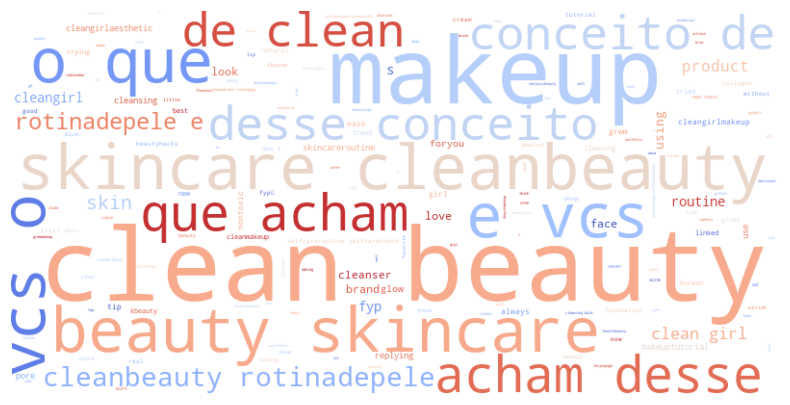

In [124]:
# 전처리된 틱톡 영상 설명 워드클라우드
wordcloud = WordCloud(width=800, height=400, 
                    background_color='white', colormap='coolwarm').generate(' '.join(df['cleaned_info'].dropna().apply(remove_stopwords)))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.title("Word Cloud - Tiktok Vedio Information")
plt.show()

In [125]:
tag_list = df['new_hash_tag']
len(tag_list)

250

In [126]:
tag_final_list = []
for i in range(len(df)):
    tags = df['new_hash_tag'][i]
    tags_list = tags.split(',')
    tag_final_list.append(tags_list)
print(tag_final_list)

[['@user8022071884889'], ['#greenscreen', '#cleansers', '#skincare', '#beauty', '#beautybrand', '#wellness', '#healthyliving'], ['@MTMama3'], [''], ['#skincarescience'], ['@lifebylane'], [''], ['#cleanbeauty', '#wellness', '#lipstick', '#lipgloss', '#makeup'], ['##cleanbeauty', '#'], ['#fyp', '#makeuplook', '#cleangirlmakeup', '#cleanlook', '#naturalmakeup'], ['#hygiene', '#cleangirl', '#hygienetips'], ['#nontoxic', '#cleanbeauty', '#nontoxicbeauty', '#facewash'], ['@unnecessarily_paige', '#skincare', '#glassskin', '#glowyskin', '#skintips'], ['@EdwardZO'], ['#skincare', '#kbeauty', '#korean', '#skintok', '#kskincare', '#cleansing', '#cleansingoil', '#pores'], ['#oilcleansing', '#cleanser', '#doublecleansing', '#koreanskincare', '#pores'], ['#glassskin', '#clearskin', '#skincare', '#skincarejourney', '#healthyskin', '#viralskincare'], ['@RED', '#redchamber', '#cleanbeauty', '#blush', '#multipurposecream', '#บลัชออน'], ['#cleangirl', '#skincareroutine', '#skincaretips', '#SelfCareRoutin

In [127]:
tag_flat_list = sum(tag_final_list,[])
tag_df = pd.DataFrame({'tag':tag_flat_list})
tag_df

,tag
0,@user8022071884889
1,#greenscreen
2,#cleansers
3,#skincare
4,#beauty
...,...
821,#cleanbeauty
822,#rotinadepele
823,#skincare
824,#cleanbeauty


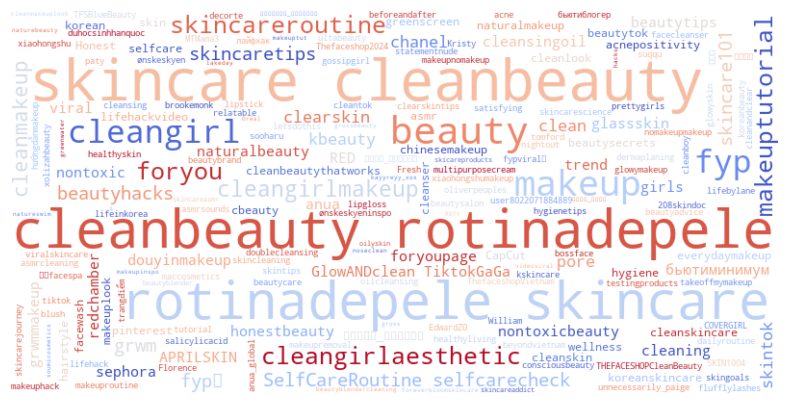

In [128]:
# 전처리된 틱톡 영상 해시태그 워드클라우드
wordcloud = WordCloud(width=800, height=400, 
                    background_color='white', colormap='coolwarm').generate(' '.join(tag_df['tag'].dropna()))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.title("Word Cloud - Tiktok Vedio Hash_tag")
plt.show()